In [2]:
from procgen_tools.imports import *
from procgen_tools.procgen_imports import *

We're going to try mean-ablating various parts of the network, and see what happens. First is the general-purpose dropdown widget. Play with it if you want.

In [3]:
NUM_SAMPLES = 100
obs = maze.get_random_obs(NUM_SAMPLES, spawn_cheese=False)

def mean_ablate(seed : int = 0, label : str = 'embedder.block3.res2.resadd_out'):
    hook.run_with_input(obs)
    random_values = hook.get_value_by_label(label)
    patches = get_mean_patch(random_values, label=label) 
    
    venv = create_venv(num=1, start_level=seed, num_levels=1)
    fig, axs, info = compare_patched_vfields(venv, patches, hook, ax_size=5, show_diff = False)

_ = interact(mean_ablate, seed=IntSlider(min=0, max=20, step=1, value=1), label=Dropdown(options=labels, value='embedder.block3.res2.resadd_out'))

interactive(children=(IntSlider(value=1, description='seed', max=20), Dropdown(description='label', index=36, …

There are several interesting layers. We can first mean-ablate the entire network and see what the "average" policy is. We'll ablate the policy at several chokepoints, as shown by the computational graph of the forward pass: 

![](https://i.imgur.com/5oSHoVQ.png) 

The relevant chokepoints are:
1. Each `Conv` and `residual add` in each Impala block, 
2. The final `Linear`, and 
3. The policy head itself. 

We want to ablate several chokepoints so as to understand how "extra computation" can happen on the ablated values. Later interventions reduce the total computation done on the mean-ablated values, but increase the amount of "averaged computation" incorporated into the network. (This still feels fuzzy to me, but I think there's something there.)

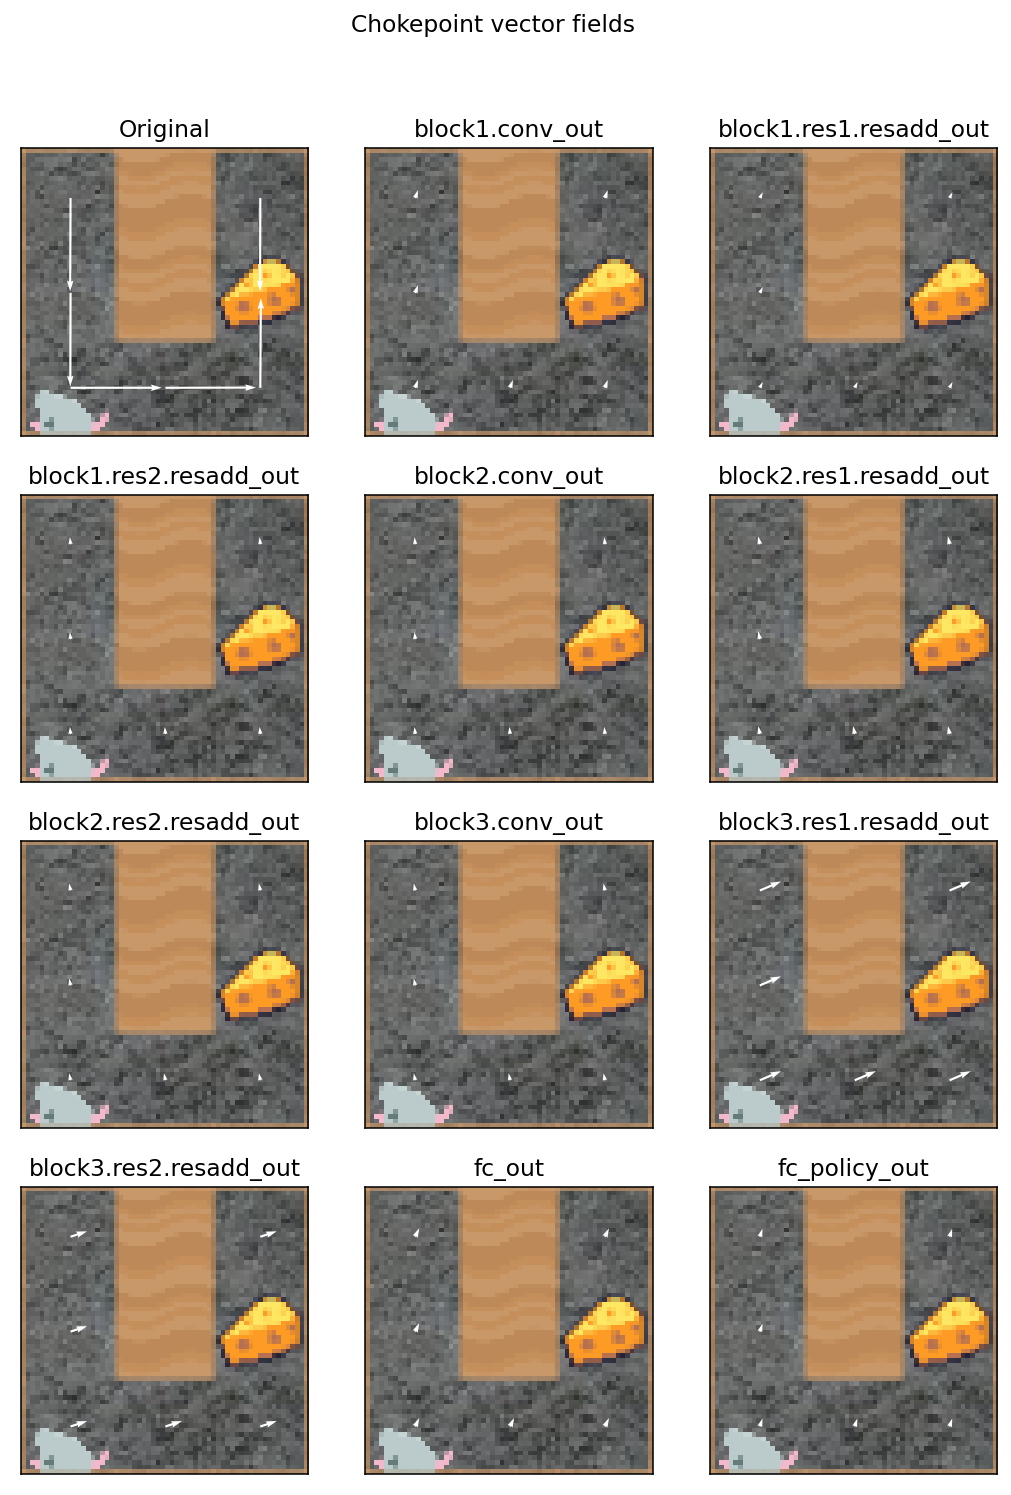

In [4]:
chokepoints = []
for block_n in range(1, 4): # 3 impala blocks
    chokepoints += [f'embedder.block{block_n}.conv_out']
    for res_n in range(1, 3): # 2 res blocks per block
        chokepoints.append(f'embedder.block{block_n}.res{res_n}.resadd_out')
chokepoints += ['embedder.fc_out', 'fc_policy_out']
# Display the original plot and then all chokepoint vector fields in one big subplots
num_axs = len(chokepoints) + 1 # This is 12
num_rows = 4
num_cols = num_axs // num_rows
assert num_axs % num_rows == 0

ax_size = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * ax_size, num_rows * ax_size))
fig.suptitle('Chokepoint vector fields')
# Ensure that the title is close to the plots
fig.subplots_adjust(top=0.9)

seed = 1

# Original plot
venv = create_venv(num=1, start_level=seed, num_levels=1)
original_vfield = vfield.vector_field(venv, hook.network)
vfield.plot_vf(original_vfield, ax=axs[0, 0])
axs[0, 0].set_title('Original')

# Chokepoint plots
for i, label in enumerate(chokepoints):
    hook.run_with_input(obs)
    random_values = hook.get_value_by_label(label)
    patches = get_mean_patch(random_values, label=label) 

    with hook.use_patches(patches):
        patched_vfield = vfield.vector_field(venv, hook.network)

    row = (i + 1) // num_cols 
    col = (i + 1) % num_cols
    vfield.plot_vf(patched_vfield, ax=axs[row, col])
    
    # Remove 'embedder' from the label
    label = re.sub(r'^embedder\.', '', label)
    axs[row, col].set_title(f'{label}')
plt.show()

This is strong evidence that, "by default", the network is biased to going up and to the right -- towards the historical top-right reinforcement zone! Next, let's look inside of each residual block, and see if we can glean anything about how cognition develops through each. 

In [5]:
residual_prefixes = [f'embedder.block{block_n}.res{res_n}' for block_n in range(1, 4) for res_n in range(1, 3)]
residual_components = ['conv1_out', 'conv2_out', 'resadd_out']

@interact
def residual_ablate(seed=IntSlider(min=0, max=20, step=1, value=0), block=Dropdown(options=[1, 2, 3], value=1), res=Dropdown(options=[1, 2], value=1), component=Dropdown(options=residual_components, value='conv1_out')):
    label = f'embedder.block{block}.res{res}.{component}'
    hook.run_with_input(obs)
    random_values = hook.get_value_by_label(label)
    patches = get_mean_patch(random_values, label=label) 
    
    venv = create_venv(num=1, start_level=seed, num_levels=1)
    fig, axs, info = compare_patched_vfields(venv, patches, hook, ax_size=5, show_diff = True)
    
    fig.suptitle(f'Mean patching layer {label}')
    plt.show()

interactive(children=(IntSlider(value=0, description='seed', max=20), Dropdown(description='block', options=(1…

As the default rendering above suggests, `block1.res1.conv1_out` can be ablated with little issue. It appears that some cheese-related computation occurs here. But this hypothesis falls apart on more careful inspection:

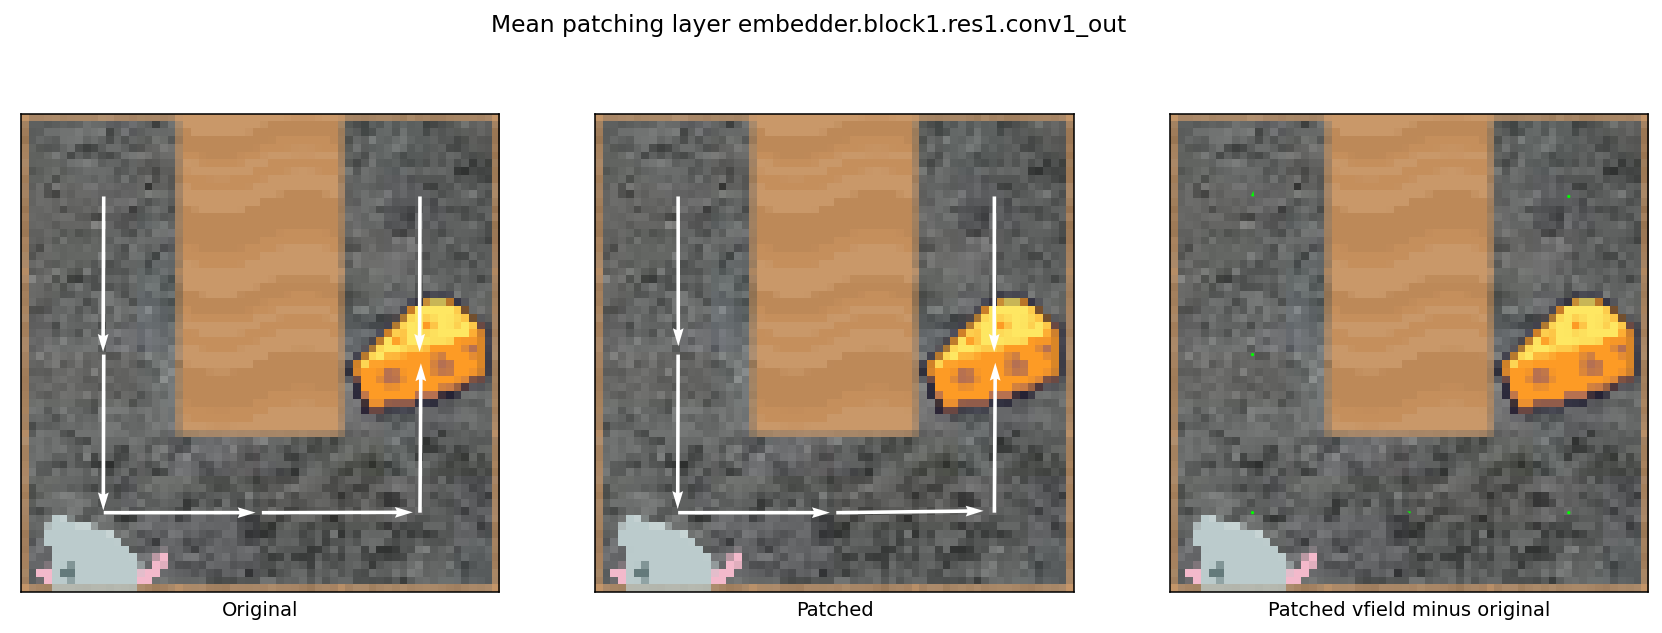

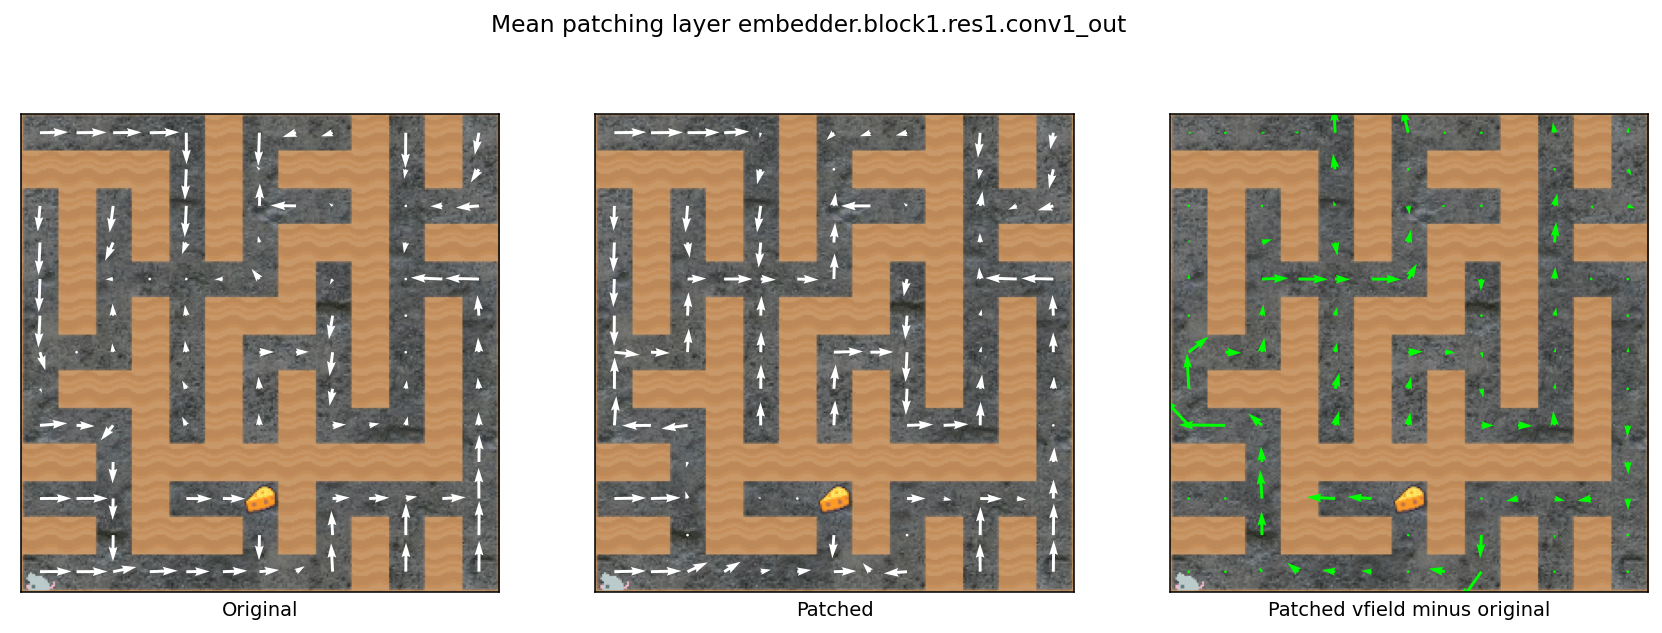

In [6]:
for seed in (1,2):
    residual_ablate(seed=seed, block=1, res=1, component='conv1_out')

When `seed=1`, ablating this layer isn't sufficient to make the agent substantially less likely to pursue the cheese. (Possibly smaller mazes were learned faster in training, and so have an even wider range of heuristics guiding the agent towards cheese, and thus are harder to patch out?) 

When `seed=2`, ablating `block1.res1.conv1_out` has a very substantial effect. 

Overall, I (Alex) don't have strong insights from mean-patching, beyond the up-right "default" behavior suggested above. I also haven't looked for very long.